# libarary

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.utils import plot_model
from keras.preprocessing import image
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
#Global initialization of some imp variables
BATCH_SIZE = 8
IMAGE_SIZE = 256
CHANNELS= 3
EPOCHS= 50

# import + explore data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/AIAP_Project/dataset/PlantVillage"

Mounted at /content/drive


In [ ]:
dir = os.listdir(dataset_path)
for filenames in dir:
    print(filenames)

Potato___Late_blight
Pepper__bell___healthy
Pepper__bell___Bacterial_spot
Potato___Early_blight
Potato___healthy


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = True,
    seed=123
    )

Found 4627 files belonging to 5 classes.


In [ ]:
len(dataset)

579

In [ ]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[1 0 0 1 1 0 3 2]


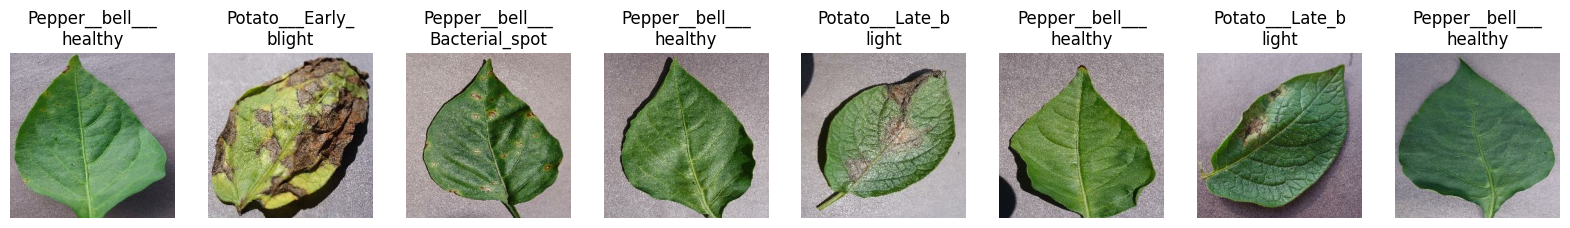

In [ ]:
from textwrap import wrap

plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(1, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title("\n".join(wrap(class_names[labels_batch[i]], 15)))
        plt.axis("off")

# Split

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("len dataset split:\n",
      "\n\t- train    : ",len(train_ds),
      "\n\t- validate : ",len(val_ds),
      "\n\t- test     : ",len(test_ds))

len dataset split:
 
	- train    :  463 
	- validate :  57 
	- test     :  59


# pre-processe

*   `cache()`: This method keeps the dataset in memory after it's loaded off disk during the first epoch. This ensures that the dataset does not become a bottleneck while training your model.
*   `shuffle(1000)`: This method randomly shuffles the items in the dataset. `1000` here defines the buffer size for shuffling. A larger buffer size ensures better shuffling but uses more memory.
*   `prefetch(buffer_size=tf.data.AUTOTUNE)`: This method allows later batches to be prepared while the current batch is being processed. This significantly improves the speed of data input. `tf.data.AUTOTUNE` allows TensorFlow to automatically tune the buffer size based on the system conditions.


---


These methods are chained together to form a pipeline that efficiently loads and preprocesses the data. The shuffled and prefetched data is ready to be fed into a model for training. The caching, shuffling, and prefetching are especially useful when working with large datasets that do not fit into memory. They allow for efficient use of memory and can significantly speed up training times.

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255), #convert the pixel values from the range [0, 255] to the range [0, 1]
])

In [ ]:
# These data augmentation layers are a crucial part of preparing your data for training.
# They help to increase the diversity of the training data, which can improve the robustness of the model.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (8, 127, 127, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (8, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (8, 62, 62, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (8, 60, 60, 64)          

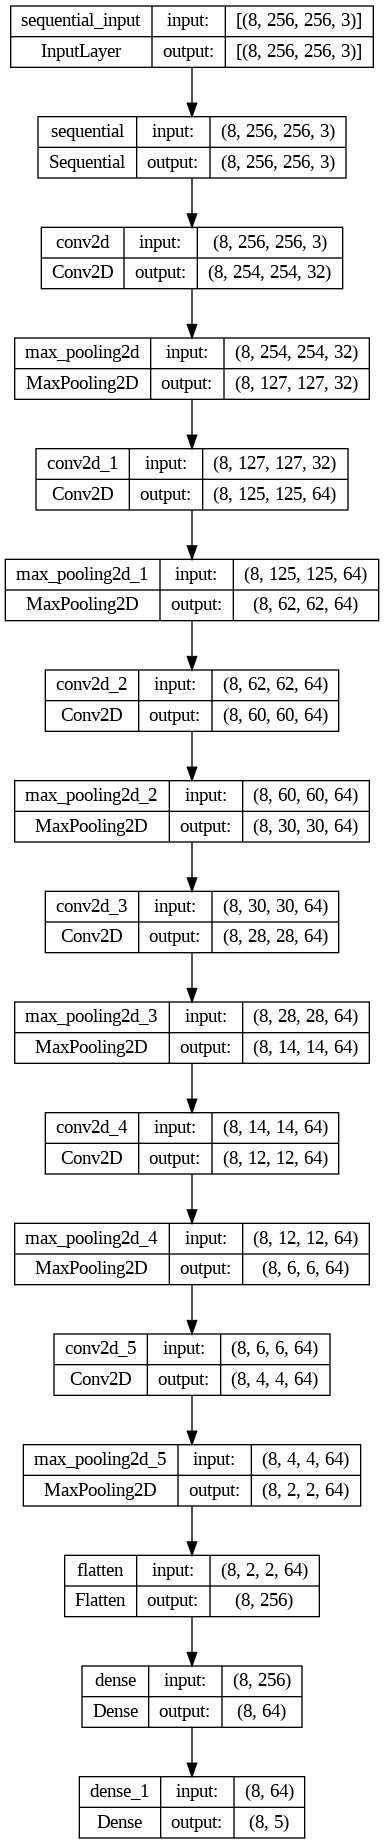

In [ ]:
plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, verbose= 1, epochs=5)

Epoch 1/5
463/463 [==============================] - 950s 1s/step - loss: 1.3034 - accuracy: 0.4280 - val_loss: 1.1403 - val_accuracy: 0.4956
Epoch 2/5
463/463 [==============================] - 460s 995ms/step - loss: 0.7055 - accuracy: 0.7434 - val_loss: 0.2778 - val_accuracy: 0.9079
Epoch 3/5
463/463 [==============================] - 463s 1s/step - loss: 0.3308 - accuracy: 0.8935 - val_loss: 0.2571 - val_accuracy: 0.9035
Epoch 4/5
463/463 [==============================] - 459s 990ms/step - loss: 0.2828 - accuracy: 0.9078 - val_loss: 0.1999 - val_accuracy: 0.9430
Epoch 5/5
463/463 [==============================] - 467s 1s/step - loss: 0.2173 - accuracy: 0.9270 - val_loss: 0.2325 - val_accuracy: 0.9211


In [ ]:
print("history:\n", history)

NameError: name 'history' is not defined

In [ ]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 463}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
print(">> accuracy     : \t", acc)
print(">> val_accuracy : \t", val_acc)
print(">> loss         : \t", loss)
print(">> val_loss     : \t", val_loss)

>> accuracy     : 	 [0.4279535114765167, 0.7434441447257996, 0.8934847116470337, 0.9078128933906555, 0.9270073175430298]
>> val_accuracy : 	 [0.49561402201652527, 0.9078947305679321, 0.9035087823867798, 0.9429824352264404, 0.9210526347160339]
>> loss         : 	 [1.303388237953186, 0.7054847478866577, 0.3307742476463318, 0.2828206717967987, 0.21732495725154877]
>> val_loss     : 	 [1.140279769897461, 0.2777897119522095, 0.25705796480178833, 0.19994017481803894, 0.2325149029493332]


In [ ]:
scores = model.evaluate(test_ds)

59/59 [==============================] - 38s 285ms/step - loss: 0.2219 - accuracy: 0.9174


In [ ]:
print("score:\n", scores)

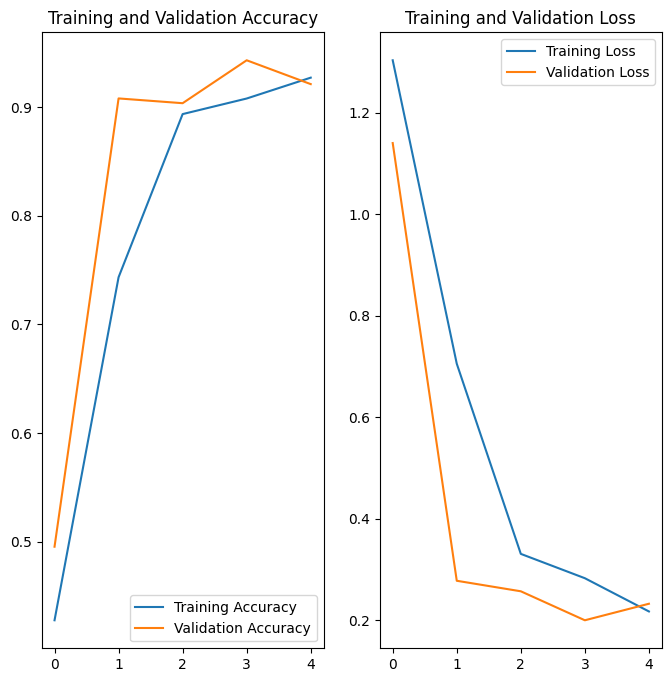

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(5), acc, label='Training Accuracy')
plt.plot(range(5), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label='Training Loss')
plt.plot(range(5), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 438ms/step
predicted label: Pepper__bell___healthy


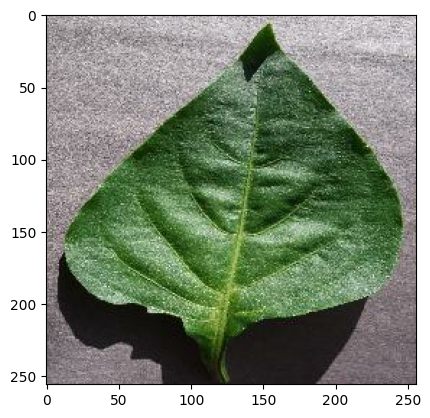

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


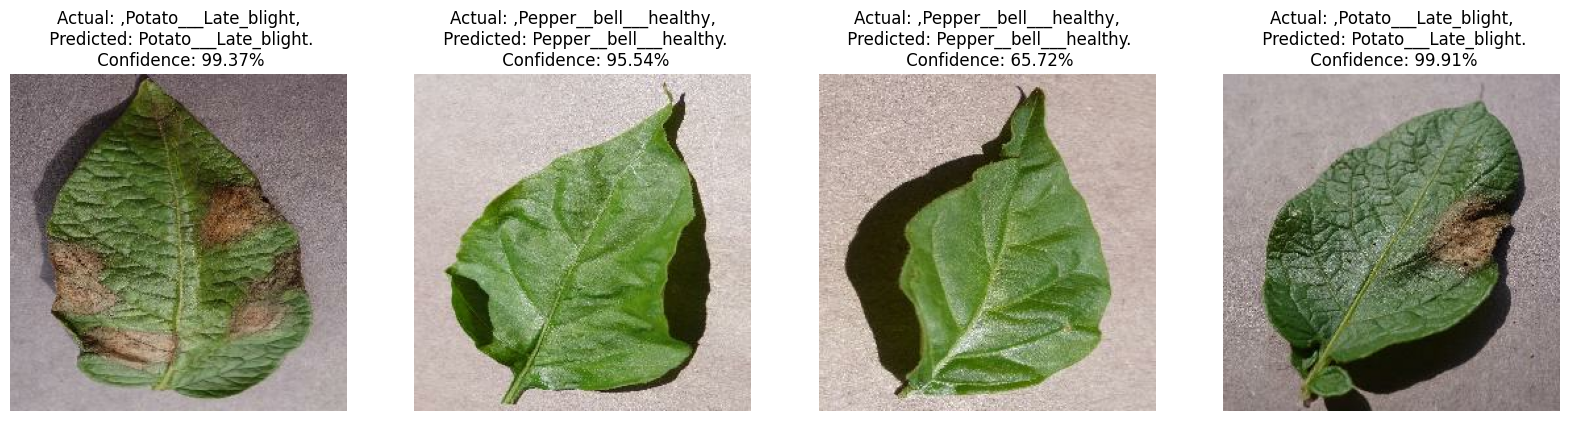

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]



        plt.title(f"Actual: ,{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save("/content/drive/MyDrive/AIAP_Project/CNN_PlantDiseaseModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
